In [1]:
from placesCNN_amul import *
import plotly.express as px
import pickle
import os
from time import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
import torch
from torchvision import transforms as trn
from geopy.geocoders import Nominatim

In [2]:
print(os.getcwd())  # C:\Users\chung\Documents\04-Insight\insight\notebooks
os.chdir('../')
print(os.getcwd())  # C:\Users\chung\Documents\04-Insight\insight

pkl_list = load_pkl_paths('notebooks/data')
input_dataset = ImageDataset('notebooks/data')
bs = 100
image_loader = torch.utils.data.DataLoader(input_dataset, batch_size=bs)
model = load_pretrained_model()

C:\Users\chung\Documents\04-Insight\insight\notebooks
C:\Users\chung\Documents\04-Insight\insight


In [4]:
start = time()
annoy_idx = getVectorIndex(model, image_loader)
end = time()

In [5]:
print('Indices generated in %.2fs.'%(end-start)) #257sec for 2529 images

Indices generated in 611.64s.


In [6]:
def get_similar(item_no, annoyIndex):
    """ Query similar images based on index of existing 
    images in the database
    Arguments:
        item_no -- index of the image to be used for querying 
        annoyIndex -- pre-built Annoy Index
    Returns:
        [indices] -- 5 nearest neighbor indices for query image
    """
#     results = annoyIndex.get_nns_by_item(item_no, 5, include_distances=True)
#     return [[a, results[1][i]] for i, a in enumerate(results[0])]
    return annoyIndex.get_nns_by_item(item_no, 5, include_distances=False)

In [7]:
print(get_similar(123,annoy_idx))

[123, 1384, 124, 690, 125]


In [36]:
def plots(indices, pd, figsize=(12,6), rows=1, titles=None, title=None):
    """
    Custom plot function to summarize the reverse image search results 
    """
    f = plt.figure(figsize=figsize)
    plt.subplots_adjust(left=0.1, bottom=0, right=0.2, top=1.02, wspace=0.02, hspace=0.02)
    plt.axis('Off')
    cols = len(indices)//rows if len(indices) % rows == 0 else len(indices)//rows + 1
    print(cols)
    for i, img_idx in enumerate(indices):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        sp.get_xaxis().set_visible(False)
        sp.get_yaxis().set_visible(False)
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        data = Image.open(pd.iloc[img_idx].path, 'r')
        data = data.convert('RGB')
        data = data.resize((400,200), Image.ANTIALIAS)
        plt.imshow(data)
        plt.tight_layout()
    plt.autoscale(tight=True)
    if title is not None:
        plt.suptitle(title, size=32)
        f.tight_layout()
        f.subplots_adjust(top=0.94)
        plt.show()
        
def plot_similar(indices, annoyIndex, pd):
    nn_output = [get_similar(i, annoyIndex) for i in indices ] #list of lists
    flat_list = np.asarray(nn_output).transpose().reshape(-1).tolist() #list
    plots(flat_list, pd, figsize=(26,22), rows=5)

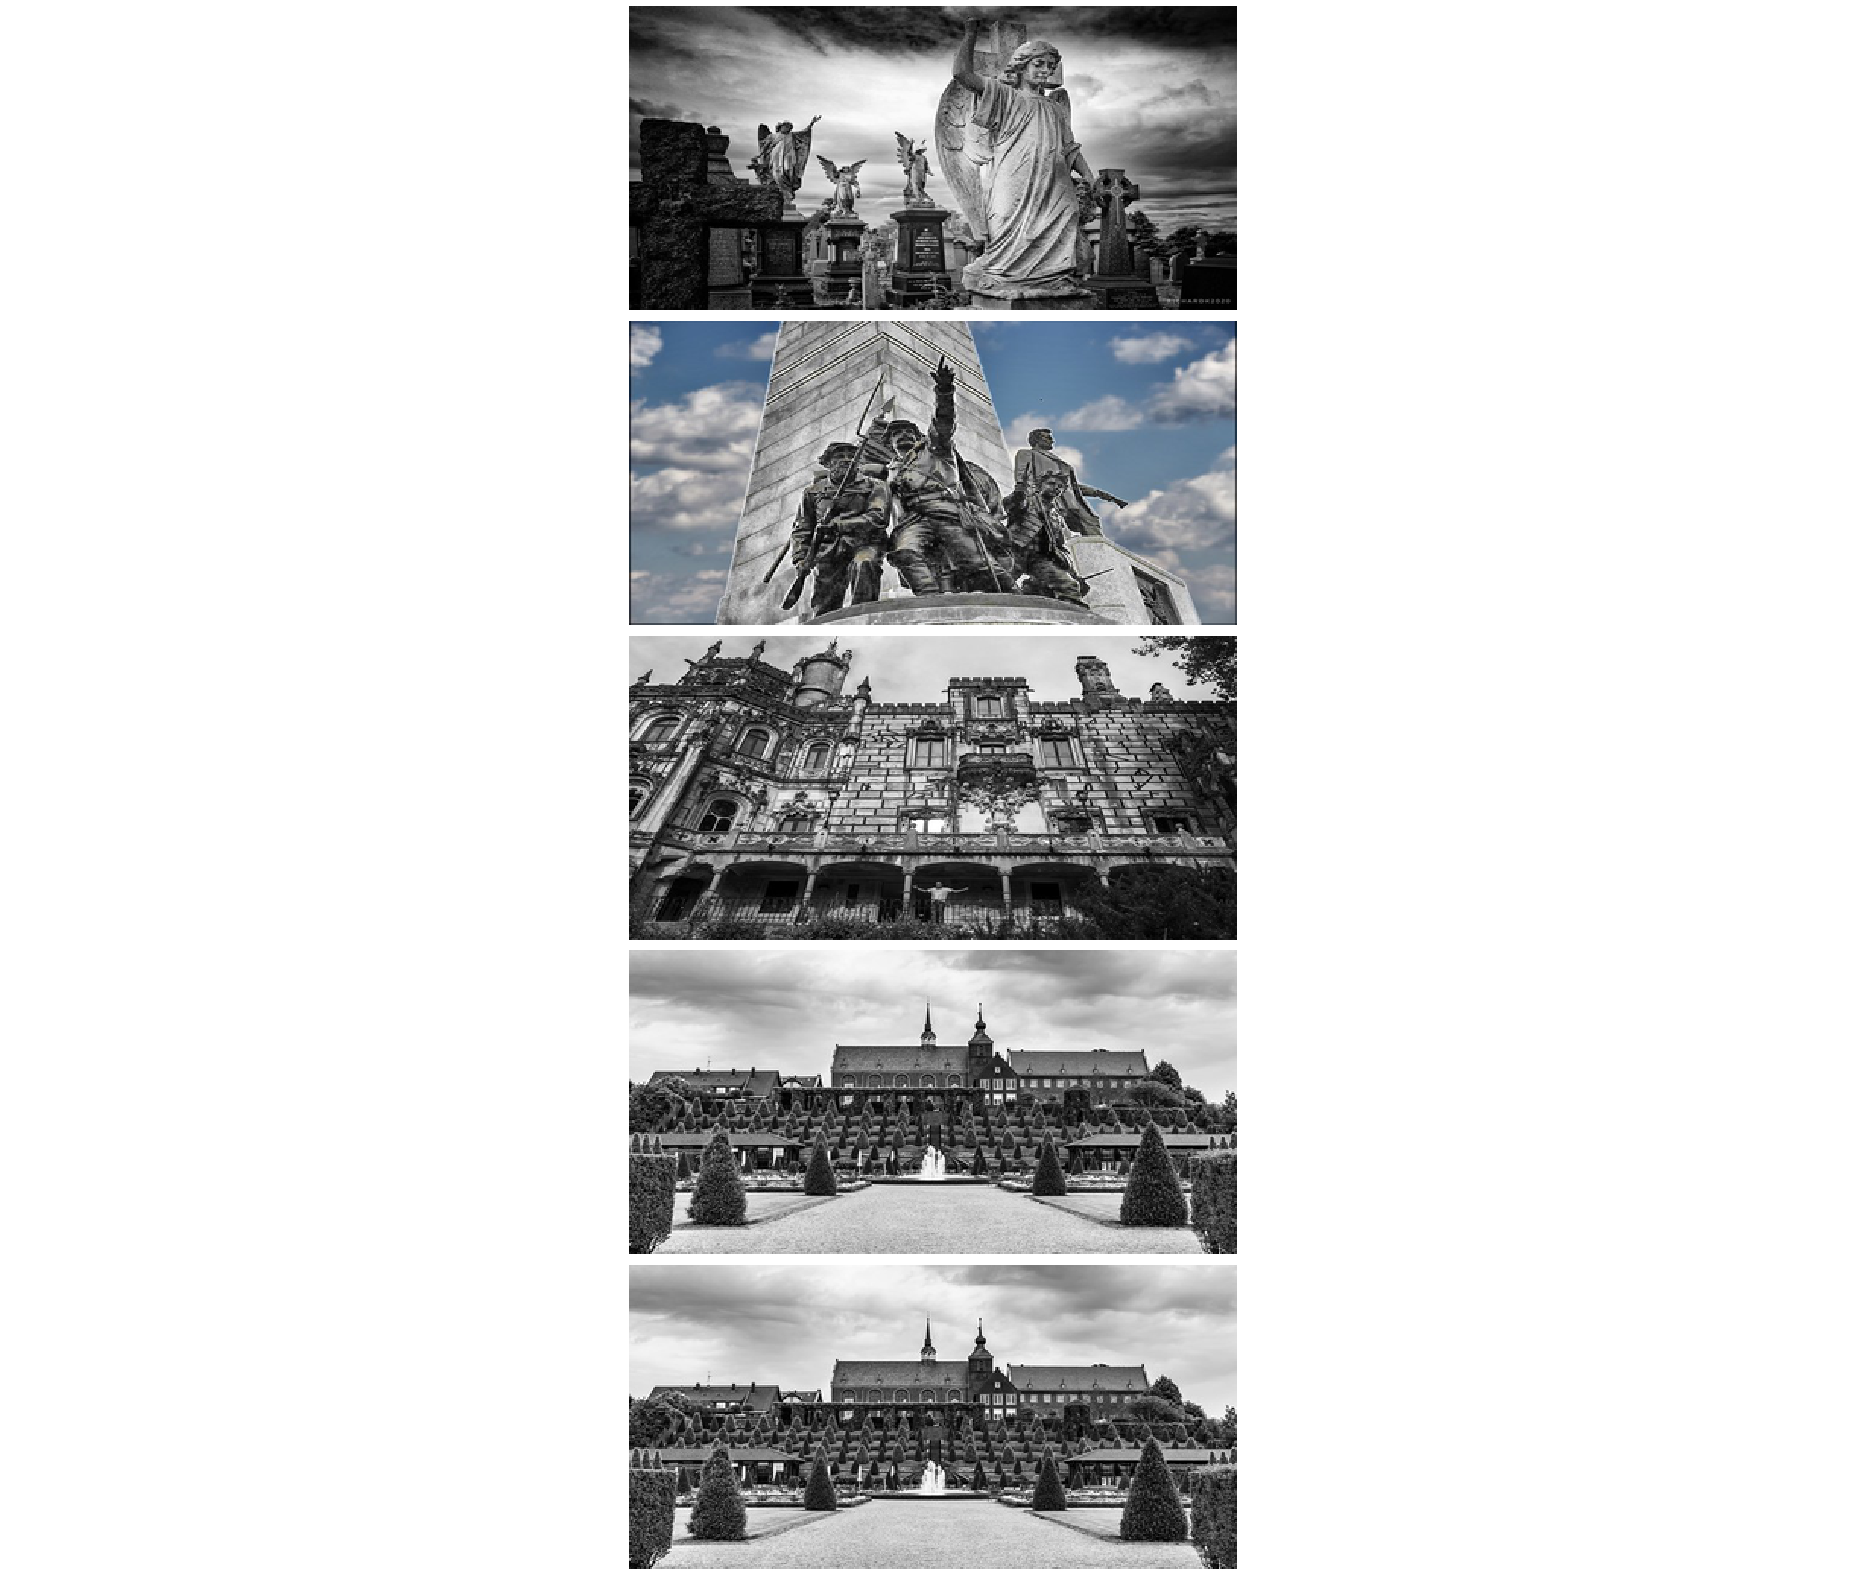

In [11]:
pd_files = input_dataset.get_file_df()
plot_similar([429], annoy_idx, pd_files)

In [12]:
import sys
sys.getsizeof(annoy_idx) #32 bytes

32

In [13]:
sys.getsizeof(pd_files) #pd_files is ~800MB

798478

In [14]:
sim = get_similar(325,annoy_idx)
print(sim)

[325, 1045, 2055, 2303, 685]


In [15]:
#for the 1st index, read pd_files for the class label
class_labels = list(pd_files.iloc[sim].label.drop_duplicates())
print(class_labels)

['butte', 'highway', 'ski slope', 'tree farm', 'desert']


In [16]:
name = list(pd_files.iloc[sim]['name'].str.rstrip('.jpg'))
print(name)

['34792135963', '49932424151', '49921641532', '32367656337', '49816575847']


In [17]:
for_plotly = pd.DataFrame(columns=['latitude','longitude'])
for label in class_labels:
    with open('notebooks/data/%s/%s.pkl'%(label,label), 'rb') as f:
        locations = pickle.load(f)
        for_plotly = pd.concat([locations.loc[locations['id'].isin(name)][['latitude','longitude']],for_plotly])
        f.close()
print(for_plotly)

     latitude    longitude
11  48.216579    11.589436
11  43.415507   -72.329585
0   59.348705    16.513717
0   48.469065   -81.422359
7   45.546860  -122.566298


In [19]:
fig = px.scatter_geo(for_plotly, lat='latitude', lon='longitude')
fig.show()

In [26]:
transform = trn.Compose([trn.Resize((256, 256)),
                               trn.CenterCrop(224),
                               trn.ToTensor(),
                               trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                              ])

def evalTestImage(test_img, model, annoy_index, top_n=5):
    '''
    Search for the closest image as the test iamge.
    :param test_img: path of test image
    :param model:
    :param annoy_index:
    :return:
    '''
    with torch.no_grad():
        model.eval()
        data = Image.open(test_img,'r').convert('RGB')
        data = transform(data).unsqueeze(0)
#         img_loader = DataLoader(data)
#         for idx, img in enumerate(img_loader):
        feature = model(data)
    searches = annoy_index.get_nns_by_vector(feature[0], top_n, include_distances=True)
    return searches[0], searches[1]

In [72]:
test_img = 'notebooks/ski-test-img.png'
searches = evalTestImage(test_img, model, annoy_idx)

In [73]:
#tuple of lists
searches

([2037, 2039, 2036, 2042, 2050],
 [0.5307708978652954,
  0.5515543818473816,
  0.5613747835159302,
  0.5889580845832825,
  0.5948405265808105])

In [25]:
annoy_path = 'notebooks/annoy_idx.annoy'
annoy_idx.save(annoy_path)

True

In [94]:
def plot_input_and_similar(test_img, searches, pd, titles=None):
    '''
    Use this function instead of plot_similar.
    test_img: text path to test image
    searches: tuple of lists. index[0] is a list of similar indices. index[1] is a list of cosine distances (flat_list)
    pd: dataframe of paths
    '''
    idx = searches[0]
    titles = searches[1]
    
    f = plt.figure(figsize=(10,15))
    plt.subplots_adjust(left=0.1, bottom=0, right=0.2, top=1.02, wspace=0.02, hspace=0.02)
    plt.axis('Off')
    rows = len(idx)
    cols = 2
    for i, img_idx in enumerate(idx):
        sp = f.add_subplot(rows, cols, 2*(i+1)) # want the output pictures on the right side
        sp.axis('Off')
        sp.get_xaxis().set_visible(False)
        sp.get_yaxis().set_visible(False)
        if titles is not None:
            sp.set_title('Cosine sim = %.3f'%titles[i], fontsize=16)
        data = Image.open(pd.iloc[img_idx].path, 'r')
        data = data.convert('RGB')
        data = data.resize((400,300), Image.ANTIALIAS)
        plt.imshow(data)
        plt.tight_layout()
    
    #plot test image
    sp = f.add_subplot(rows, cols, rows) # want the test image in the middle of the column
    sp.axis('Off')
    sp.get_xaxis().set_visible(False)
    sp.get_yaxis().set_visible(False)
    sp.set_title('User Input', fontsize=16)
    data = Image.open(test_img, 'r')
    data = data.convert('RGB')
    data = data.resize((400,300), Image.ANTIALIAS)
    plt.imshow(data)
    plt.tight_layout()
        
    plt.autoscale(tight=True)
#     if fig_title is not None:
#         plt.suptitle(titles, size=32)
#         f.tight_layout()
#         f.subplots_adjust(top=0.94)
#         plt.show()

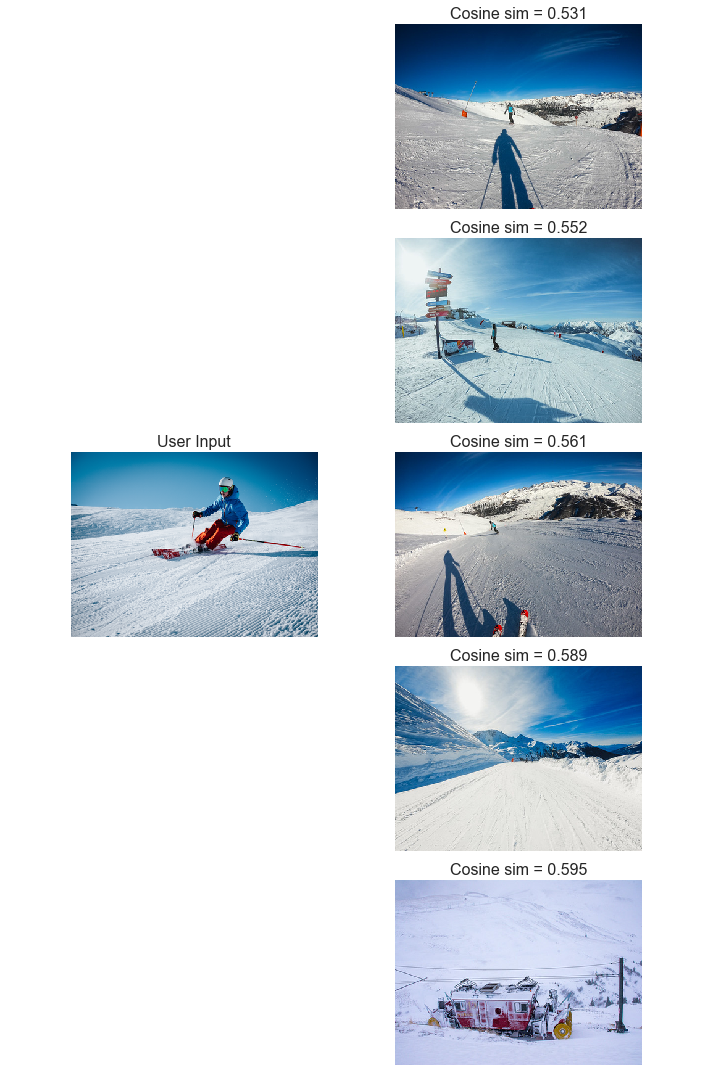

In [95]:
plot_input_and_similar(test_img, searches, pd_files)

In [172]:


def plot_map(searches):
    
    idx = searches[0] #list of annoy index results
    class_labels = list(pd_files.iloc[idx].label.drop_duplicates())
    name = list(pd_files.iloc[idx]['name'].str.rstrip('.jpg')) # list of photo id's
    
    for_plotly = pd.DataFrame(columns=['latitude','longitude'])
    for label in class_labels:
        with open('notebooks/data/%s/%s.pkl'%(label,label), 'rb') as f:
            locations = pickle.load(f)
            for_plotly = pd.concat([locations.loc[locations['id'].isin(name)][['latitude','longitude']],for_plotly])
            f.close()
    for_plotly = for_plotly.reset_index(drop=True)
    keys_for_display = ['state','country']
    gl = Nominatim(user_agent='default')
    for_plotly['latlon'] = list(zip(for_plotly['latitude'],for_plotly['longitude']))   
    locations = []
    display_names = []
    for i, row in for_plotly.iterrows():
        location = gl.reverse(for_plotly.iloc[i]['latlon'])
        locations.append(location.address)
        display_names.append(", ".join([location.raw['address'][key] for key in keys_for_display]))
#         locations.append(gl.reverse(for_plotly.iloc[i]['latlon']))
#     addresses = [", ".join([location.raw['address'][key] for key in keys_for_address]) for location in locations]  
    for_plotly['address'] = locations
    for_plotly['display'] = display_names
    print(for_plotly)

    fig = px.scatter_geo(for_plotly, lat='latitude', lon='longitude', text='display')
    fig.show()

In [173]:
plot_map(searches)

    latitude longitude                 latlon  \
0  46.584266  7.959591  (46.584266, 7.959591)   
1  44.595661  6.647216  (44.595661, 6.647216)   
2  44.596538  6.641991  (44.596538, 6.641991)   
3  44.585163  6.655455  (44.585163, 6.655455)   
4  44.586405  6.657025  (44.586405, 6.657025)   

                                             address  \
0  1116y, Mendelssohnweg, Hannegg, Felsengrund, L...   
1  Razis V22, Liaison Vars, Rebrun, Vars, Brianço...   
2  Saluces, Les Florins, Risoul, Briançon, Hautes...   
3  Mayt V5, Vallon, Les Florins, Risoul, Briançon...   
4  Peyrol V16, Vallon, Les Florins, Risoul, Brian...   

                              display  
0             Bern/Berne, Switzerland  
1  Provence-Alpes-Côte d'Azur, France  
2  Provence-Alpes-Côte d'Azur, France  
3  Provence-Alpes-Côte d'Azur, France  
4  Provence-Alpes-Côte d'Azur, France  


In [107]:
gl = Nominatim(user_agent='default')

In [108]:
location = gl.reverse('44.586405,6.657025')
print(location.address) # can trim to 'village' or 'municipality' level

Peyrol V16, Vallon, Les Florins, Risoul, Briançon, Hautes-Alpes, Provence-Alpes-Côte d'Azur, France métropolitaine, 05600, France


In [124]:
keys_for_address = ['hamlet','village','municipality','county','state','postcode','country']
address = ", ".join([location.raw['address'][key] for key in keys_for_address])
print(address)

Les Florins, Risoul, Briançon, Hautes-Alpes, Provence-Alpes-Côte d'Azur, 05600, France


In [167]:
print(location.raw)

{'place_id': 580379, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'node', 'osm_id': 226930833, 'lat': '44.587643', 'lon': '6.6546661', 'display_name': "Peyrol V16, Vallon, Les Florins, Risoul, Briançon, Hautes-Alpes, Provence-Alpes-Côte d'Azur, France métropolitaine, 05600, France", 'address': {'aerialway': 'Peyrol V16', 'road': 'Vallon', 'hamlet': 'Les Florins', 'village': 'Risoul', 'municipality': 'Briançon', 'county': 'Hautes-Alpes', 'state': "Provence-Alpes-Côte d'Azur", 'country': 'France', 'postcode': '05600', 'country_code': 'fr'}, 'boundingbox': ['44.587593', '44.587693', '6.6546161', '6.6547161']}
